# Rule overlap between Train and Test set using different splitting techniques

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from collections import defaultdict

from rule.rule_utils import rule_overlap
from utils.plot_config import *
mpl.rc('lines', linewidth=plot_line_width)
fontsize = fontsize * 1.3

In [2]:
# Before running this notebook make sure to execute the following commands, to create the necessary datasets:
# ! python data/coveo_preproc.py -p data/data_sources/coveo_ecommerce
# ! python data/retailrocket_preproc.py -p data/data_sources/retailrocket_ecommerce
# ! python data/rees46_preproc.py -p data/data_sources/ress46_ecommerce

In [3]:
experiments = {
    "coveo": {
        "full_path": "data/data_sources/coveo_ecommerce/coveo_processed_view_full.tsv",
        "train_path": "data/data_sources/coveo_ecommerce/coveo_processed_view_train_full.tsv",
        "test_path": "data/data_sources/coveo_ecommerce/coveo_processed_view_test.tsv",
    },
    "retailrocket": {
        "full_path": "data/data_sources/retailrocket_ecommerce/retailrocket_processed_view_full.tsv",
        "train_path": "data/data_sources/retailrocket_ecommerce/retailrocket_processed_view_train_full.tsv",
        "test_path": "data/data_sources/retailrocket_ecommerce/retailrocket_processed_view_test.tsv",
    },
    "rees46": {
        "full_path": "data/data_sources/rees46_ecommerce/rees46_processed_view_full.tsv",
        "train_path": "data/data_sources/rees46_ecommerce/rees46_processed_view_train_full.tsv",
        "test_path": "data/data_sources/rees46_ecommerce/rees46_processed_view_test.tsv",
    },
}

### Calculateing rule overlap between train and test

- leave-one-out: For each session longer than 2, the last event is assigned to the test set, the remaining events are assigned to the train set.
- timebased split: sessions after a timestamp are assigned to the test set, events before are assigned to the train set
    - The split time is calculated to yield the same test size as the "leave-one_out" technique.
- leave-one-out with timebased split: sessions after a timestamp are assigned to the test set, events before are assigned to the train set
    - Scores are only calculated on the last event of the test sessions.
- leave-one-out with random split: randomly sampled sessions (number of sessions match with the number of sessions in leave-one-out with timebased split) are assigned to the test set, the rest of the sessions are assigned to the train set.
    - Scores are only calculated on the last event of the test sessions.

In [4]:
for dataset_name, dataset_params in experiments.items():
    rule_overlap(**dataset_params)

Calculating rule overlap for: coveo
	Calculating overlap for 'leave-one-out' technique
		train shape: (1327759, 3) test shape: (271772, 3) test events: 135886
		train_ratio: 0.9072 test_ratio: 0.0928
		overlap: 0.37009572
	Calculating overlap for 'timebased split' technique, with test size adjusted to l1o test size 0.0928
		train shape: (1305602, 3) test shape: (157447, 3) test events: 135869
		train_ratio: 0.8920 test_ratio: 0.0928
		overlap: 0.38123896
	Calculating overlap for 'leave-one-out with timebased split' technique
		train shape: (1411113, 3) test shape: (15496, 3) test events: 7748
		overlap: 0.45004198
	Calculating overlap for 'leave-one-out with random split' technique
		train shape: (1455897, 3) test shape: (15496, 3) test events: 7748
		overlap: 0.44424060
Calculating rule overlap for: retailrocket
	SKIPPING, file exists: data/results/rule_overlap/retailrocket_rule_overlap.tsv
Calculating rule overlap for: rees46
	SKIPPING, file exists: data/results/rule_overlap/rees46_r

In [5]:
def format_plot(ax):
    ax.legend(loc=1, prop={'size': fontsize})
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(plot_axis_line_width)
    ax.tick_params(width=plot_axis_line_width)
    ax.tick_params(axis='y', which='major', labelsize=fontsize*0.95)
    ax.tick_params(axis='x', which='major', labelsize=fontsize*1.2)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
    

In [6]:
def create_barplot(ax, dataset_names, dataset_stats):
    x = np.arange(len(dataset_names))
    width = 0.3
    multiplier = 0
    bar_colors = [colors["color_1"], colors["color_0"]]
    for i, (attribute, measurement) in enumerate(dataset_stats.items()):
        measurement = np.array(measurement)
        offset = width * multiplier
        bars = ax.bar(x + offset, measurement, width, label=attribute, color=bar_colors[i%2])
        ax.bar_label(bars, labels=[f"{m:.4f}" for m in measurement], padding=0, fontsize=fontsize*0.85)
        multiplier += 1
    ax.set_ylabel('Ratio', fontsize=fontsize*1.2)
    ax.set_xticks(x + width/2, dataset_names)
    format_plot(ax)
    plt.show()

In [7]:
def load_dataset_stats(dataset_names):
    dataset_stats = defaultdict(list)
    file_path = "./data/results/rule_overlap"
    overlap_file_names = os.listdir(file_path)
    for dataset_name in dataset_names:
        overlap_file_name = next((fn for fn in overlap_file_names if dataset_name.lower() in fn), None)
        if overlap_file_name is None:
            raise ValueError(f"There is no matching overlap file for dataset: {dataset_name}")
        data = pd.read_csv(os.path.join(file_path, overlap_file_name), sep='\t')
        for i in range(len(data)):
            dataset_stats[data.iloc[i, data.columns.get_loc("method")]].append(data.iloc[i, data.columns.get_loc("overlap")])

    return dataset_stats

In [8]:
dataset_names = np.array(["Rees46", "Coveo", "Retailrocket"])
dataset_stats = load_dataset_stats(dataset_names)
dataset_stats_fig1 = {"Leave-one-out": dataset_stats["Leave-one-out"], "Time based": dataset_stats["Time based"]}
dataset_stats_fig2 = {"Leave-one-out: random": dataset_stats["Leave-one-out: random"], "Leave-one-out: time split": dataset_stats["Leave-one-out: time split"]}

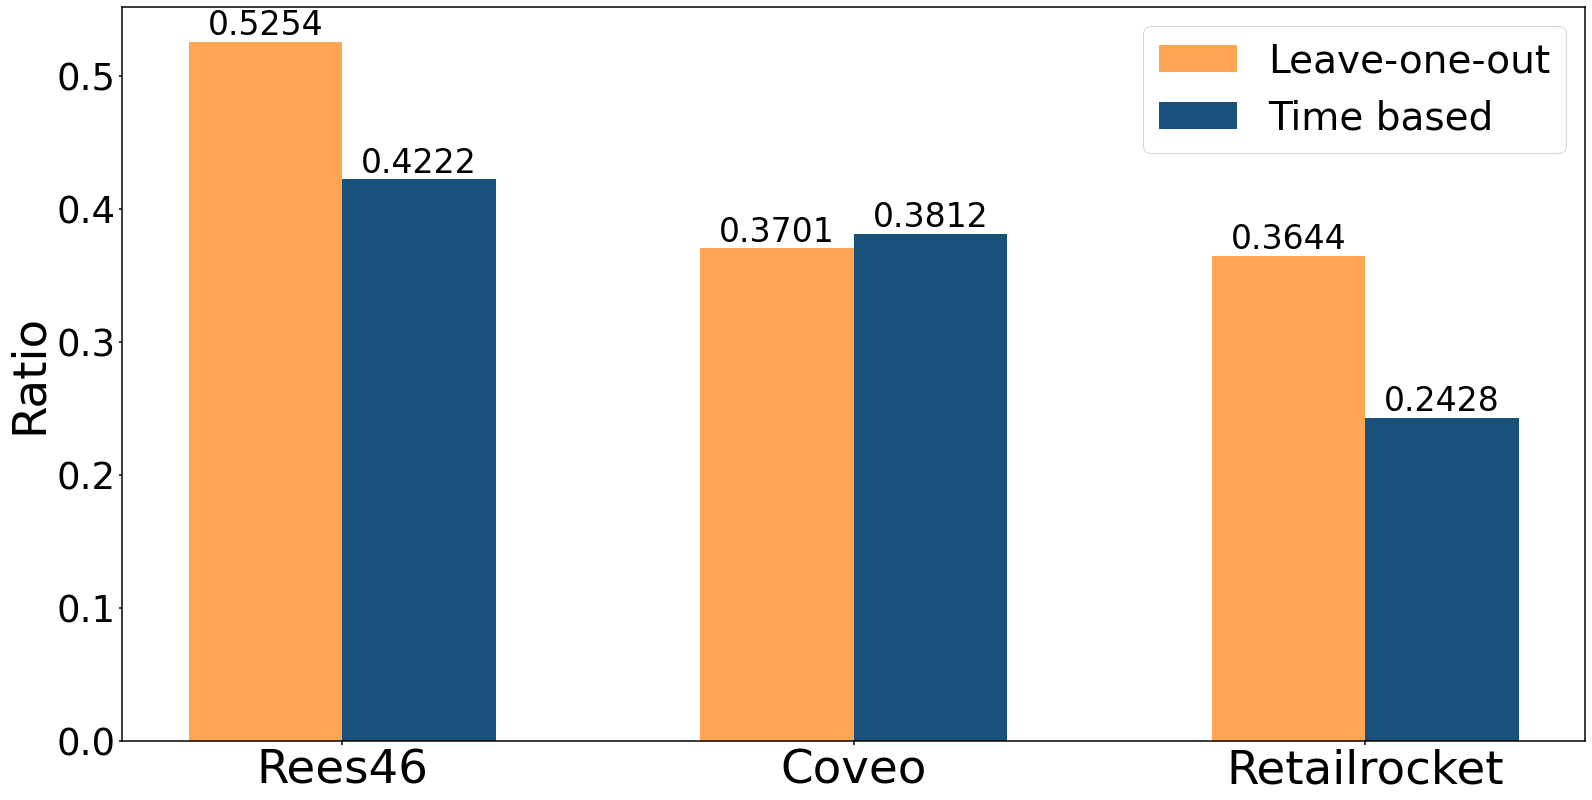

In [9]:
fig, ax = plt.subplots(figsize=(22,11), layout="constrained")
create_barplot(ax, dataset_names, dataset_stats_fig1)

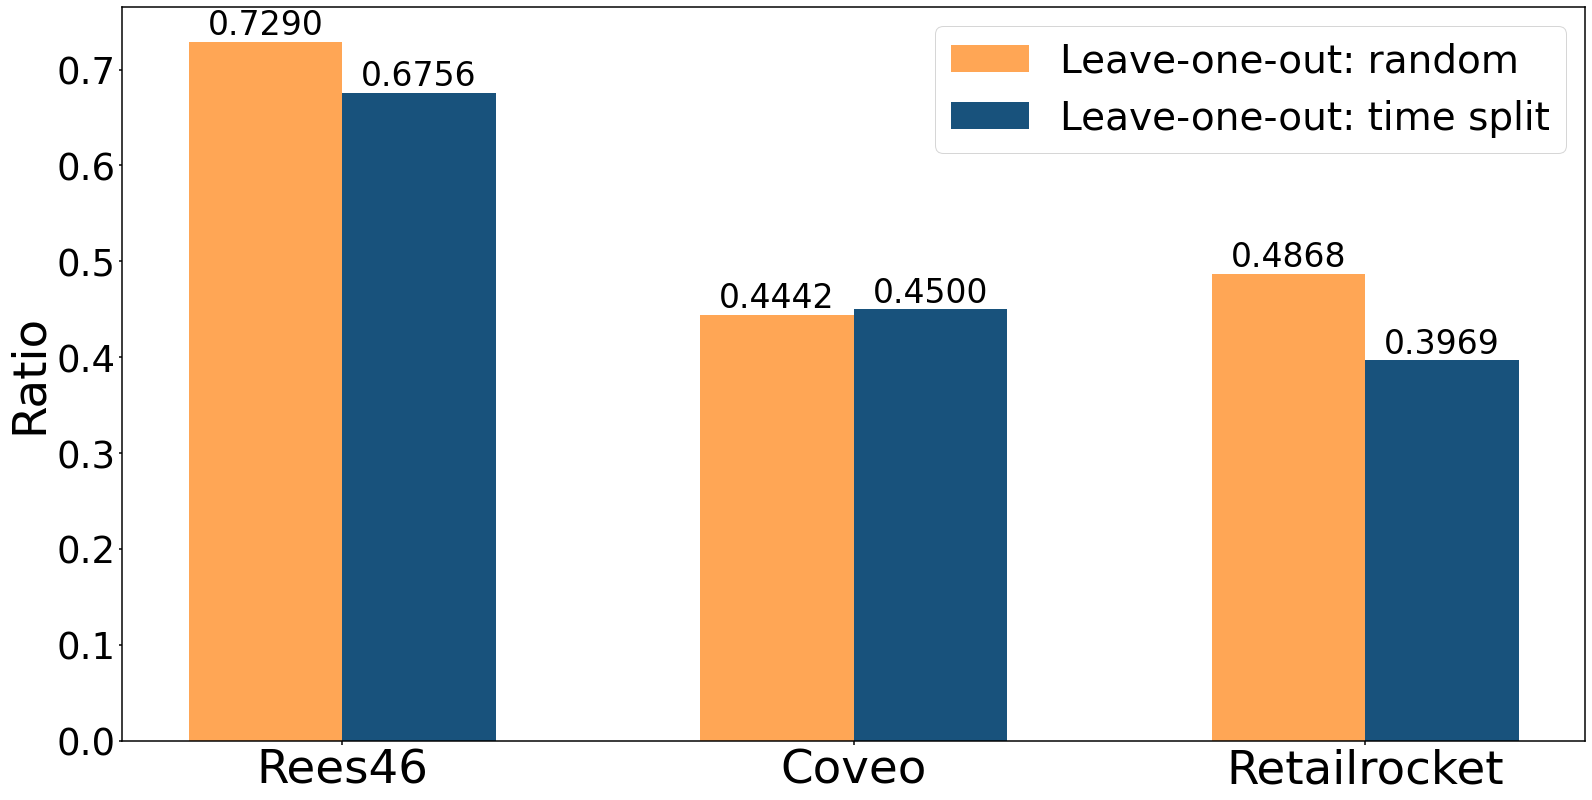

In [10]:
fig, ax = plt.subplots(figsize=(22,11), layout="constrained")
create_barplot(ax, dataset_names, dataset_stats_fig2)